In [1]:
# Import and setup
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
import gc
%matplotlib inline

In [15]:
# Read data
df_train = pd.read_csv('train_V2.csv', nrows=None)

# Drop NA
df_train = df_train.dropna()
print(df_train.shape)
df_train.head()

(4446965, 29)


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [16]:
# Define class to preprocess raw data
class DfTransformer:
    def __init__(self):
        self.mean_rankpoints = None
        self.mean_killpoints = None
        self.mean_winpoints = None
        self.df_test_meta = None
    
    def transform_train(self, df):
        # Replace None values of rankPoints with mean
        col_rankpoints = df['rankPoints']
        col_rankpoints = col_rankpoints.loc[col_rankpoints > 1e-4]
        self.mean_rankpoints = col_rankpoints.mean()
        # print('The mean of non-none rankPoints is %.3f' % mean_rankpoints)
        df.loc[df['rankPoints'] < 1e-4, 'rankPoints'] = self.mean_rankpoints
        
        # Replace None values of killPoints with mean
        col_killpoints = df['killPoints']
        col_killpoints = col_killpoints.loc[col_killpoints > 1e-4]
        self.mean_killpoints = col_killpoints.mean()
        # print('The mean of non-none killPoints is %.3f' % mean_killpoints)
        df.loc[df['killPoints'] < 1e-4, 'killPoints'] = self.mean_killpoints
        
        # Replace None values of winPoints with mean
        col_winpoints = df['winPoints']
        col_winpoints = col_winpoints.loc[col_winpoints > 1e-4]
        self.mean_winpoints = col_winpoints.mean()
        # print('The mean of non-none winPoints is %.3f' % mean_winpoints)
        df.loc[df['winPoints'] < 1e-4, 'winPoints'] = self.mean_winpoints
        
        # Feature engineering
        return self.feature_engineering(df, is_train=True)
    
    def transform_test(self, df):
        return self.transform_test_directly(df, self.mean_rankpoints,
                                            self.mean_killpoints, self.mean_winpoints)
    
    def transform_test_directly(self, df, mean_rankpoints, mean_killpoints, mean_winpoints):
        # Replace None values of rankPoints, killPoints, winPoints
        df.loc[df['rankPoints'] < 1e-4, 'rankPoints'] = mean_rankpoints
        df.loc[df['killPoints'] < 1e-4, 'killPoints'] = mean_killpoints
        df.loc[df['winPoints'] < 1e-4, 'winPoints'] = mean_winpoints
        
        # Feature engineering
        return self.feature_engineering(df, is_train=False)
    
    def transform_prediction(self, df_meta, y_predicted):
        df_y = df_meta.copy()
        df_y['winPlacePerc'] = y_predicted
        return (self.df_test_meta.merge(df_y, on=['matchId', 'groupId'], how='left'))[['Id', 'winPlacePerc']]
    
    def feature_engineering(self, df, is_train=True):
        # Add hand-engineered features
        df_walkDistance = df['walkDistance'] + 5
        df['heals_over_dist'] = df['heals'] / df_walkDistance
        df['boosts_over_dist'] = df['boosts'] / df_walkDistance
        df['kills_over_dist'] = df['kills'] / df_walkDistance
        df['headshots_over_dist'] = df['headshotKills'] / df_walkDistance
        df['killStreaks_over_dist'] = df['killStreaks'] / df_walkDistance
        df['damageDealt_over_dist'] = df['damageDealt'] / df_walkDistance
        df['dbnos_over_dist'] = df['DBNOs'] / df_walkDistance
        df['weapons_over_dist'] = df['weaponsAcquired'] / df_walkDistance
        df['revives_over_dist'] = df['revives'] / df_walkDistance
        df_walkDistance = None
        df_kills = df['kills'] + 0.001
        df['headshots_over_kills'] = df['headshotKills'] / df_kills
        df['killStreaks_over_kills'] = df['killStreaks'] / df_kills
        df_kills = None
        df['teamwork'] = df['assists'] + df['revives']
        df['totalDistance'] = df['walkDistance'] + df['rideDistance'] + df['swimDistance']
        df['items'] = df['heals'] + df['boosts']
        df['skills'] = df['headshotKills'] + df['roadKills']
        # df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace'] # No improvement
        
        features = df.columns.tolist()
        features.remove('Id')
        features.remove('groupId')
        features.remove('matchId')
        features.remove('matchType')
        if is_train: features.remove('winPlacePerc')
            
        # Define method to map column names (adding suffix)
        def map_col_names(df, features, suffix):
            col_name_dict = {}
            for name in features:
                col_name_dict[name] = name + suffix
            return df.rename(columns=col_name_dict)
            
        # Add group mean and group mean rank in match
        group_by = df.groupby(['matchId','groupId'])
        group_by_features = group_by[features]
        df_agg = group_by_features.agg('mean')
        df_agg_rank = df_agg.groupby('matchId')[features].rank(pct=True).reset_index()
        df_out = df_agg.reset_index().merge(df_agg_rank, on=['matchId', 'groupId'], how='left',
                                            suffixes=["_groupMean", "_groupMeanRank"])

        # Add group max and group max rank in match
        df_agg = group_by_features.agg('max')
        df_agg_rank = df_agg.groupby('matchId')[features].rank(pct=True).reset_index()
        df_agg = df_agg.reset_index().merge(df_agg_rank, on=['matchId', 'groupId'], how='left',
                                            suffixes=["_groupMax", "_groupMaxRank"])
        df_out = df_out.merge(df_agg, on=['matchId', 'groupId'], how='left')

        # Add group min and group min rank in match
        df_agg = group_by_features.agg('min')
        df_agg_rank = df_agg.groupby('matchId')[features].rank(pct=True).reset_index()
        df_agg = df_agg.reset_index().merge(df_agg_rank, on=['matchId', 'groupId'], how='left',
                                            suffixes=["_groupMin", "_groupMinRank"])
        df_out = df_out.merge(df_agg, on=['matchId', 'groupId'], how='left')
        
        # Add group sum and group sum rank in match
        df_agg = group_by_features.agg('sum')
        df_agg_rank = df_agg.groupby('matchId')[features].rank(pct=True).reset_index()
        df_agg = df_agg.reset_index().merge(df_agg_rank, on=['matchId', 'groupId'], how='left',
                                            suffixes=["_groupSum", "_groupSumRank"])
        df_out = df_out.merge(df_agg, on=['matchId', 'groupId'], how='left')
        
        # Add group std
        df_out = df_out.merge(group_by_features.agg('std').reset_index(), on=['matchId', 'groupId'], how='left')
        df_out = df_out.fillna(0)  # zero divisor is present for single player group
        df_out = map_col_names(df_out, features, '_groupStd')
        group_by_features = None
        
        # Add group size
        df_agg = group_by.size().to_frame('groupSize').reset_index()
        df_out = df_out.merge(df_agg, on=['matchId', 'groupId'], how='left')

        # Add target if for training
        if is_train:
            df_agg = group_by[['winPlacePerc']].first().reset_index()
            df_out = df_out.merge(df_agg, on=['matchId', 'groupId'], how='left')
            
        # Add match mean
        group_by = df.groupby(['matchId'])
        group_by_features = group_by[features]
        df_out = df_out.merge(group_by_features.agg('mean').reset_index(), on=['matchId'], how='left')
        df_out = map_col_names(df_out, features, '_matchMean')
        
        # Add match max
        df_out = df_out.merge(group_by_features.agg('max').reset_index(), on=['matchId'], how='left')
        df_out = map_col_names(df_out, features, '_matchMax')
        
        # Add match min
        df_out = df_out.merge(group_by_features.agg('min').reset_index(), on=['matchId'], how='left')
        df_out = map_col_names(df_out, features, '_matchMin')
        
        # Add match sum
        df_out = df_out.merge(group_by_features.agg('sum').reset_index(), on=['matchId'], how='left')
        df_out = map_col_names(df_out, features, '_matchSum')
        
        # Add match std
        df_out = df_out.merge(group_by_features.agg('std').reset_index(), on=['matchId'], how='left')
        df_out = df_out.fillna(0)
        df_out = map_col_names(df_out, features, '_matchStd')
        group_by_features = None
        
        # Add match size
        df_agg = group_by['groupId'].nunique().to_frame('matchSize').reset_index()
        df_out = df_out.merge(df_agg, on=['matchId'], how='left')

        # Add encoded matchType (no improvement)
        # df_agg = group_by['matchType'].first().reset_index()
        # df_out = df_out.merge(df_agg, on=['matchId'], how='left')
        # df_out = pd.get_dummies(df_out, columns=['matchType']) # Ont-hot encoding
        # df_out['matchType'] = df_out['matchType'].astype('category').cat.codes # Label encoding
        
        # Keep metadata of df_test for later restoring individual prediction
        if not is_train:
            self.df_test_meta = df[['Id', 'matchId', 'groupId']]
        
        # Return: features, metadata, weights
        return df_out.drop(columns=['matchId', 'groupId']),\
               df_out[['matchId', 'groupId']],\
               df_out['groupSize'].values

# Unit test for DfPreprocessor
df_bbb = df_train.iloc[:6, :].copy()
df_bbb.iloc[0, 26] = 0
df_bbb.iloc[1:5, 2] = df_bbb.iloc[0, 2]
df_bbb.iloc[1:3, 1] = df_bbb.iloc[0, 1]
df_bbb.iloc[1:3, 28] = df_bbb.iloc[0, 28]
df_bbb, df_bbb_meta, bbb_weights = DfTransformer().transform_train(df_bbb)
df_bbb

,assists_groupMean,boosts_groupMean,damageDealt_groupMean,DBNOs_groupMean,headshotKills_groupMean,heals_groupMean,killPlace_groupMean,killPoints_groupMean,kills_groupMean,killStreaks_groupMean,longestKill_groupMean,matchDuration_groupMean,maxPlace_groupMean,numGroups_groupMean,rankPoints_groupMean,revives_groupMean,rideDistance_groupMean,roadKills_groupMean,swimDistance_groupMean,teamKills_groupMean,vehicleDestroys_groupMean,walkDistance_groupMean,weaponsAcquired_groupMean,winPoints_groupMean,heals_over_dist_groupMean,boosts_over_dist_groupMean,kills_over_dist_groupMean,headshots_over_dist_groupMean,killStreaks_over_dist_groupMean,damageDealt_over_dist_groupMean,dbnos_over_dist_groupMean,weapons_over_dist_groupMean,revives_over_dist_groupMean,headshots_over_kills_groupMean,killStreaks_over_kills_groupMean,teamwork_groupMean,totalDistance_groupMean,items_groupMean,skills_groupMean,assists_groupMeanRank,boosts_groupMeanRank,damageDealt_groupMeanRank,DBNOs_groupMeanRank,headshotKills_groupMeanRank,heals_groupMeanRank,killPlace_groupMeanRank,killPoints_groupMeanRank,kills_groupMeanRank,killStreaks_groupMeanRank,longestKill_groupMeanRank,matchDuration_groupMeanRank,maxPlace_groupMeanRank,numGroups_groupMeanRank,rankPoints_groupMeanRank,revives_groupMeanRank,rideDistance_groupMeanRank,roadKills_groupMeanRank,swimDistance_groupMeanRank,teamKills_groupMeanRank,vehicleDestroys_groupMeanRank,walkDistance_groupMeanRank,weaponsAcquired_groupMeanRank,winPoints_groupMeanRank,heals_over_dist_groupMeanRank,boosts_over_dist_groupMeanRank,kills_over_dist_groupMeanRank,headshots_over_dist_groupMeanRank,killStreaks_over_dist_groupMeanRank,damageDealt_over_dist_groupMeanRank,dbnos_over_dist_groupMeanRank,weapons_over_dist_groupMeanRank,revives_over_dist_groupMeanRank,headshots_over_kills_groupMeanRank,killStreaks_over_kills_groupMeanRank,teamwork_groupMeanRank,totalDistance_groupMeanRank,items_groupMeanRank,skills_groupMeanRank,assists_groupMax,boosts_groupMax,damageDealt_groupMax,DBNOs_groupMax,headshotKills_groupMax,heals_groupMax,killPlace_groupMax,killPoints_groupMax,kills_groupMax,killStreaks_groupMax,longestKill_groupMax,matchDuration_groupMax,maxPlace_groupMax,numGroups_groupMax,rankPoints_groupMax,revives_groupMax,rideDistance_groupMax,roadKills_groupMax,swimDistance_groupMax,teamKills_groupMax,vehicleDestroys_groupMax,walkDistance_groupMax,weaponsAcquired_groupMax,winPoints_groupMax,heals_over_dist_groupMax,boosts_over_dist_groupMax,kills_over_dist_groupMax,headshots_over_dist_groupMax,killStreaks_over_dist_groupMax,damageDealt_over_dist_groupMax,dbnos_over_dist_groupMax,weapons_over_dist_groupMax,revives_over_dist_groupMax,headshots_over_kills_groupMax,killStreaks_over_kills_groupMax,teamwork_groupMax,totalDistance_groupMax,items_groupMax,skills_groupMax,assists_groupMaxRank,boosts_groupMaxRank,damageDealt_groupMaxRank,DBNOs_groupMaxRank,headshotKills_groupMaxRank,heals_groupMaxRank,killPlace_groupMaxRank,killPoints_groupMaxRank,kills_groupMaxRank,killStreaks_groupMaxRank,longestKill_groupMaxRank,matchDuration_groupMaxRank,maxPlace_groupMaxRank,numGroups_groupMaxRank,rankPoints_groupMaxRank,revives_groupMaxRank,rideDistance_groupMaxRank,roadKills_groupMaxRank,swimDistance_groupMaxRank,teamKills_groupMaxRank,vehicleDestroys_groupMaxRank,walkDistance_groupMaxRank,weaponsAcquired_groupMaxRank,winPoints_groupMaxRank,heals_over_dist_groupMaxRank,boosts_over_dist_groupMaxRank,kills_over_dist_groupMaxRank,headshots_over_dist_groupMaxRank,killStreaks_over_dist_groupMaxRank,damageDealt_over_dist_groupMaxRank,dbnos_over_dist_groupMaxRank,weapons_over_dist_groupMaxRank,revives_over_dist_groupMaxRank,headshots_over_kills_groupMaxRank,killStreaks_over_kills_groupMaxRank,teamwork_groupMaxRank,totalDistance_groupMaxRank,items_groupMaxRank,skills_groupMaxRank,assists_groupMin,boosts_groupMin,damageDealt_groupMin,DBNOs_groupMin,headshotKills_groupMin,heals_groupMin,killPlace_groupMin,killPoints_groupMin,kills_groupMin,killStreaks_groupMin,longestKill_gro

In [17]:
# Preprocess data
df_transformer = DfTransformer()
df_train, df_train_meta, weight_train = df_transformer.transform_train(df_train)

print('here 1')
persist_processed_data = False  # For debug
if persist_processed_data:
    df_train.to_csv('df_train.csv', index=False)
    df_train_meta.to_csv('df_train_meta.csv', index=False)
    df_train_weight = pd.DataFrame()
    df_train_weight['weight_train'] = weight_train
    df_train_weight.to_csv('df_train_weight.csv', index=False)

In [2]:
# For debug: load processed data from saved file directly
df_train = pd.read_csv('df_train.csv')
df_train_meta = pd.read_csv('df_train_meta.csv')
df_train_weight = pd.read_csv('df_train_weight.csv')
weight_train = df_train_weight['weight_train'].values
df_train_weight = None

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# df_train = reduce_mem_usage(df_train)

In [4]:
# Get X and y
y_train = df_train['winPlacePerc'].values
X_train = df_train.drop(columns='winPlacePerc').values

feature_name = df_train.columns
df_train = None

print(X_train.shape)
gc.collect()

(2026744, 548)


11

In [5]:
# Standardize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# Persist scaler if needed
persist_scaler = False
if persist_scaler:
    df_scaler = pd.DataFrame()
    df_scaler['scale'] = scaler.scale_
    df_scaler['mean'] = scaler.mean_
    df_scaler['var'] = scaler.var_
    df_scaler.to_csv('training_scaler.csv', index=False)

In [22]:
# Define method to get k-fold CV MAE
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

def report_mae_sklearn(model, X, y, weight, K=2):
    kf = KFold(n_splits=K, shuffle=True)
    maes = []
    for idx_train, idx_valid in kf.split(X):
        print('processing fold...')
        X_train = X[idx_train]
        y_train = y[idx_train]
        X_valid = X[idx_valid]
        y_valid = y[idx_valid]
        weight_train = weight[idx_train]
        weight_valid = weight[idx_valid]
        
        model.fit(X_train, y_train, sample_weight=weight_train)
        y_predicted = model.predict(X_valid)
        mae = mean_absolute_error(y_valid, y_predicted, sample_weight=weight_valid)
        print('current MAE: %.5f' % mae)
        maes.append(mae)
    return np.array(maes).mean()

In [10]:
# Compute MAE by 2-fold CV
mae_mean = report_mae_sklearn(LinearRegression(), X_train, y_train, weight_train, 2)
print('Linear Regression MAE: %.5f' % mae_mean)

processing fold...
current MAE: 0.03937
processing fold...
current MAE: 0.03930
Linear Regression MAE: 0.03933


In [7]:
# Train model
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train, sample_weight=weight_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [8]:
# Define method to plot feature importance
def plot_feature_importance(feature_importance, feature_name):
    idx_sorted = np.argsort(feature_importance)
    importance_sorted = feature_importance[idx_sorted]
    name_sorted = [feature_name[i] for i in idx_sorted]
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.barh(np.arange(feature_importance.size), importance_sorted, tick_label=name_sorted)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

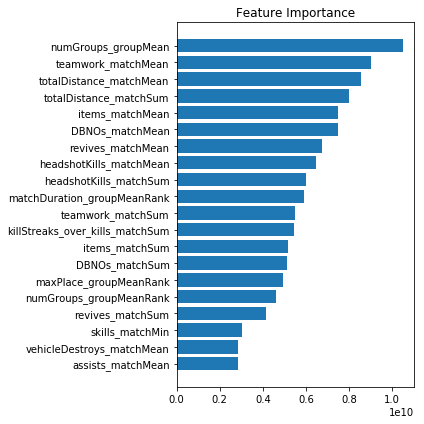

In [9]:
# Plot feature importance
topK = 20
feature_importance = np.abs(model.coef_) # Feature coef
idx_sorted = np.argsort(feature_importance)
idx_topK = idx_sorted[-1:-topK-1:-1]

plot_feature_importance(feature_importance[idx_topK], feature_name[idx_topK].tolist())

In [11]:
# Save model
from joblib import dump

dump(model, 'LR.joblib') 

['LR.joblib']